#LOADING PACKAGES

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

LOADING DATA

In [6]:
stores=pd.read_csv("C:\\Users\\nisha\\OneDrive\\Desktop\\FORAGE-PROJECT\\QUANTIUM-PROJECT\\QVI_data.csv")

#DELETING DUPLICATE

In [7]:
stores.drop_duplicates(inplace=True)

In [21]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264833 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264833 non-null  int64         
 1   DATE              264833 non-null  datetime64[ns]
 2   STORE_NBR         264833 non-null  int64         
 3   TXN_ID            264833 non-null  int64         
 4   PROD_NBR          264833 non-null  int64         
 5   PROD_NAME         264833 non-null  object        
 6   PROD_QTY          264833 non-null  int64         
 7   TOT_SALES         264833 non-null  float64       
 8   PACK_SIZE         264833 non-null  int64         
 9   BRAND             264833 non-null  object        
 10  LIFESTAGE         264833 non-null  object        
 11  PREMIUM_CUSTOMER  264833 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 26.3+ MB


CHANGING DATE  FORMAT

In [ ]:
stores["DATE"]=pd.to_datetime(stores["DATE"],dayfirst=True)

EXTRACTING MONTH FROM DATE

In [9]:
stores['MONTH'] = stores['DATE'].dt.to_period('M')

EXTRACTING MONTHLY METRICS FROM DATE 

In [10]:
monthly_metrics=stores.groupby(["MONTH","STORE_NBR"]).agg(
    TOTAL_SPEND=("TOT_SALES","sum"),
    TOTAL_CUSTOMER=("LYLTY_CARD_NBR",pd.Series.nunique),
    TRANSACTION=("LYLTY_CARD_NBR","count"),
                  ).reset_index()

CREATING COLUMN avg_txn_per_customer  FOR MORE MAKING DATE MORE EFFECTIVE

In [13]:
monthly_metrics['avg_txn_per_customer'] = monthly_metrics['TRANSACTION'] / monthly_metrics['TOTAL_CUSTOMER']


In [36]:
monthly_metrics.head()

,MONTH,STORE_NBR,TOTAL_SPEND,TOTAL_CUSTOMER,TRANSACTION,avg_txn_per_customer
0,2018-07,1,206.9,49,52,1.061224
1,2018-07,2,150.8,39,41,1.051282
2,2018-07,3,1205.7,112,138,1.232143
3,2018-07,4,1399.9,128,160,1.250000
4,2018-07,5,812.0,93,120,1.290323


In [ ]:
def get_control_store(trial_store, df, pre_start, pre_end):
    # Filter pre-trial period
    trial_data = df[(df['STORE_NBR'] == trial_store) &
                    (df['MONTH'] >= pre_start) &
                    (df['MONTH'] <= pre_end)].copy()

    scores = []

    for store in df['STORE_NBR'].unique():
        if store == trial_store:
            continue

        control_data = df[(df['STORE_NBR'] == store) &
                          (df['MONTH'] >= pre_start) &
                          (df['MONTH'] <= pre_end)].copy()

        if len(trial_data) != len(control_data):
            continue  # must be same time length

         # Compute correlation and magnitude similarity
        corr_sales = np.corrcoef(trial_data['TOTAL_SPEND'], control_data['TOTAL_SPEND'])[0, 1]
        corr_customers = np.corrcoef(trial_data['TOTAL_CUSTOMER'], control_data['TOTAL_CUSTOMER'])[0, 1]
        corr_txns = np.corrcoef(trial_data['avg_txn_per_customer'], control_data['avg_txn_per_customer'])[0, 1]

        overall_similarity = np.nanmean([corr_sales, corr_customers, corr_txns])
        scores.append((store, overall_similarity))

    scores_df = pd.DataFrame(scores, columns=['control_store', 'similarity_score'])
    top_match = scores_df.sort_values(by='similarity_score', ascending=False).iloc[0]
    return top_match

# Step 4: Define time periods
pre_start = pd.Period('2018-07')
pre_end = pd.Period('2018-12')
trial_start = pd.Period('2019-01')
trial_end = pd.Period('2019-03')

# Step 5: Match control stores for each trial store
trial_stores = [77, 86, 88]
control_results = []

for trial in trial_stores:
    result = get_control_store(trial, monthly_metrics, pre_start, pre_end)
    result['trial_store'] = trial
    control_results.append(result)

control_df = pd.DataFrame(control_results)
print(control_df)



In [16]:
# Step 6: Compare trial and control store during trial
def compare_stores(trial_store, control_store, df, trial_start, trial_end):
    trial_data = df[(df['STORE_NBR'] == trial_store) & (df['MONTH'] >= trial_start) & (df['MONTH'] <= trial_end)].copy()
    control_data = df[(df['STORE_NBR'] == control_store) & (df['MONTH'] >= trial_start) & (df['MONTH'] <= trial_end)].copy()

    trial_data['type'] = 'Trial'
    control_data['type'] = 'Control'

    comparison = pd.concat([trial_data, control_data])
    return comparison
# Step 7: Example visualization for store 77
trial_store = 77
control_store = control_df[control_df['trial_store'] == trial_store]['control_store'].values[0]
compare_df = compare_stores(trial_store, control_store, monthly_metrics, trial_start, trial_end)



In [ ]:
compare_df['MONTH'] = compare_df['MONTH'].astype(str)

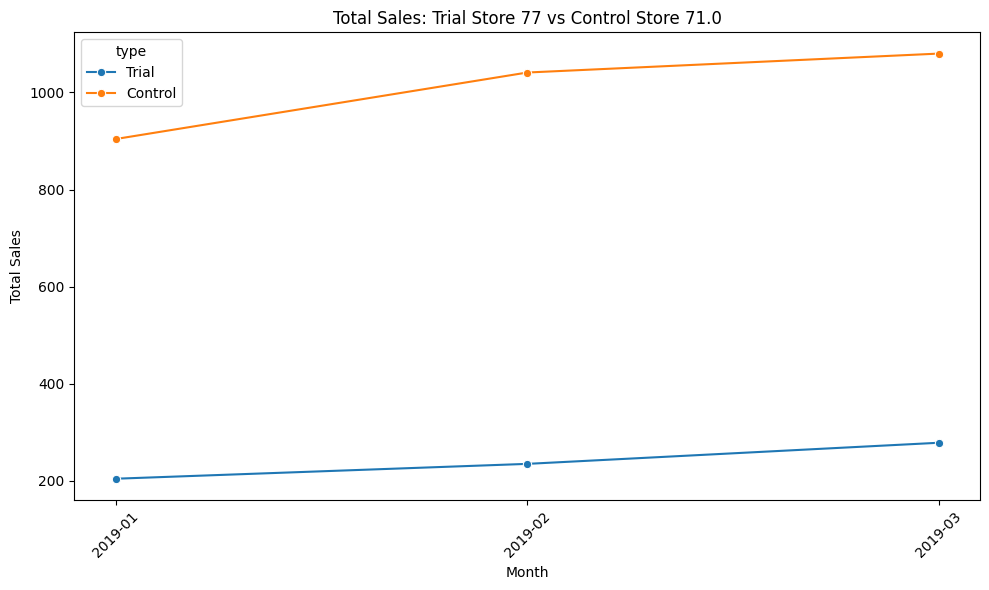

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=compare_df, x='MONTH', y='TOTAL_SPEND', hue='type', marker='o')
plt.title(f"Total Sales: Trial Store {trial_store} vs Control Store {control_store}")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
#monthly_metrics.info()
monthly_metrics["MONTH"]= monthly_metrics["MONTH"].astype(str)

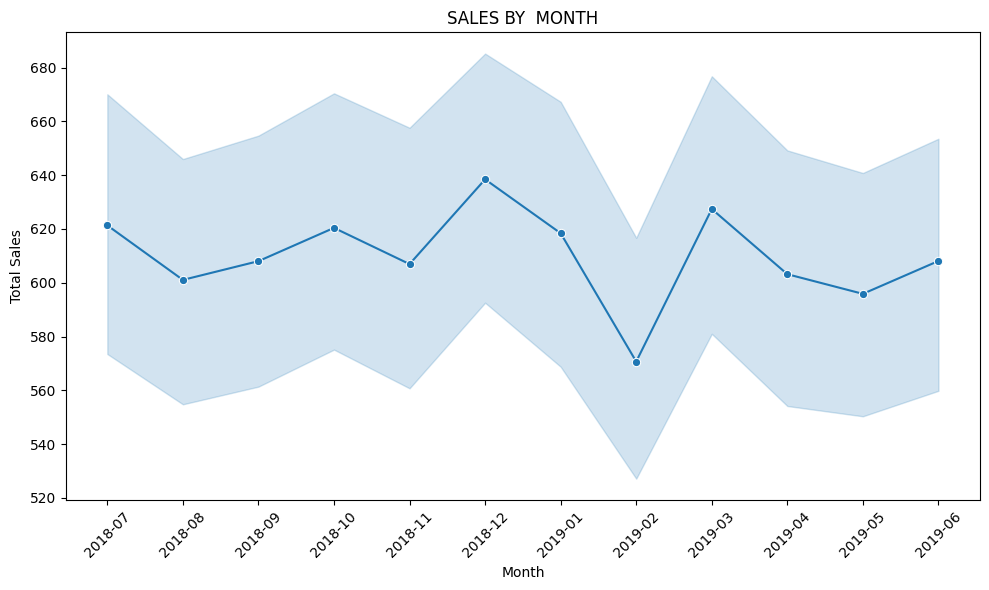

In [44]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_metrics, x='MONTH', y='TOTAL_SPEND', marker='o')
plt.title(f"SALES BY  MONTH")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
compare_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1658 to 2180
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MONTH                 6 non-null      object 
 1   STORE_NBR             6 non-null      int64  
 2   TOTAL_SPEND           6 non-null      float64
 3   TOTAL_CUSTOMER        6 non-null      int64  
 4   TRANSACTION           6 non-null      int64  
 5   avg_txn_per_customer  6 non-null      float64
 6   type                  6 non-null      object 
dtypes: float64(2), int64(3), object(2)
memory usage: 384.0+ bytes


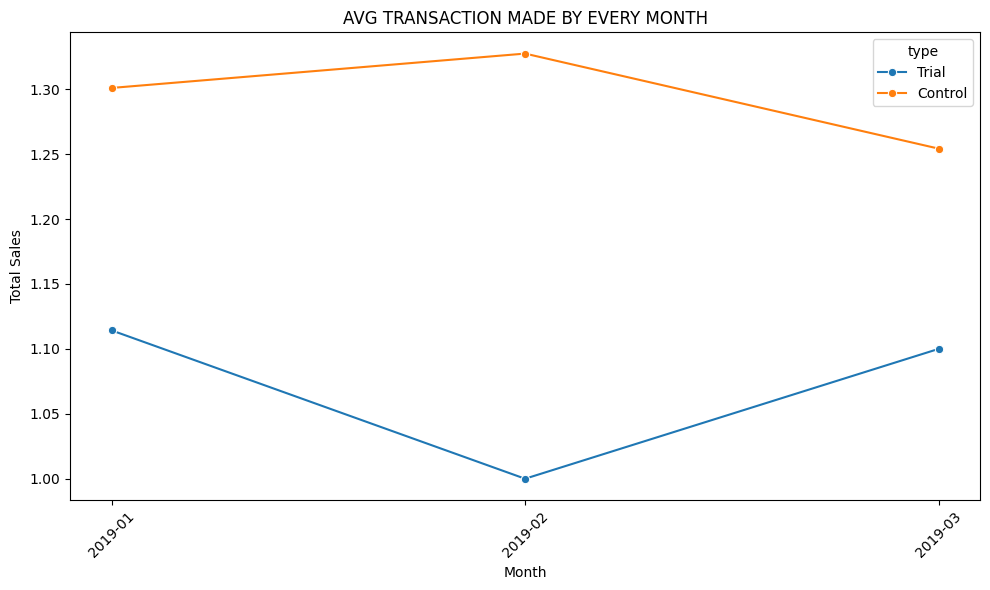

In [52]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=compare_df, x='MONTH', y='avg_txn_per_customer',hue='type', marker='o')
plt.title(f"AVG TRANSACTION MADE BY EVERY MONTH")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
